## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab 

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

mv: cannot stat 'kaggle.json': No such file or directory
ref                                                                                deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection               2023-06-14 23:59:00  Featured         $1,000,000        623           False  
https://www.kaggle.com/competitions/asl-signs                                      2023-05-01 23:59:00  Research           $100,000       1117           False  
https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction      2023-06-08 23:59:00  Research           $100,000        724           False  
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction  2023-05-18 23:59:00  Featured            $60,000       

## Download Dataset from Kaggle

In [ ]:
!kaggle competitions download -c bci-homework-3-kaggle-judge
!unzip -qq bci-homework-3-kaggle-judge.zip -d ./
!ls -l BCI_hw3_dataset

100% 282M/282M [00:17<00:00, 23.1MB/s]
100% 282M/282M [00:17<00:00, 16.9MB/s]
total 16
-rw-r--r-- 1 root root  269 Apr 12 08:33 data_detail.json
drwxr-xr-x 2 root root 4096 Apr 26 02:48 labeled_test
drwxr-xr-x 2 root root 4096 Apr 26 02:48 train
drwxr-xr-x 2 root root 4096 Apr 26 02:48 unlabeled_test


## Install Package (Optional)

In [ ]:
!pip install torchinfo
!pip install mne
!pip install scipy
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Package and Library to Python Session

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EEG Model

### EEGNet

In [48]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### ShallowConvNet

In [49]:
class ShallowConvNet(nn.Module):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    NT: int
        Number of temporal filters.
    NS: int
        Number of spatial filters.
    tkerLen: int
        Length of the temporal filter.
    pool_tLen: int
        Length of temporal pooling filter.
    pool_tStep: int
        Length of stride of temporal pooling filters.
    batch_norm: bool
        Whether to use batch normalization.
    dropRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1703.05051
    """
    def __init__(self, C, N, nb_classes, NT=40, NS=40, tkerLen=12, pool_tLen=35, pool_tStep=7, batch_norm=True, dropRate=0.25):
        super(ShallowConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, NT, (1, tkerLen), bias=False)
        self.conv2 = nn.Conv2d(NT, NS, (C, 1), bias=False)
        self.Bn1 = nn.BatchNorm2d(NS)
        self.AvgPool1 = nn.AvgPool2d((1, pool_tLen), stride=(1, pool_tStep))
        self.Drop1 = nn.Dropout(dropRate)
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.AvgPool1(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [50]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        # self.layer = ...
        # the implement detail is in the report
        #To be brief, i just replace conv2d+permute to conv3d+squeeze/unsqueeze
        self.Nu    = Nu
        self.Nc    = Nc
        self.conv1 = nn.Conv2d(1,Nu,(C,Nt))
        #self.per   = Permute2d(shape = (0,2,1,3))
        self.bn1   = nn.BatchNorm2d(Nu)
        self.conv2 = nn.Conv3d(1,Nc,kernel_size=(Nu,1,12))
        self.bn2   = nn.BatchNorm2d(Nc)
        self.dp    = nn.Dropout(0.5)
        self.avg   = nn.AvgPool2d((1,62),stride=(1,12))
        self.fc    = nn.Linear(820,nb_classes)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.per(x)
        x = self.bn1(x)
        #print(x.shape)
        x = x.unsqueeze(1)
        #print(x.shape) #torch.Size([16, 1, 22, 1, 562])
        x = self.conv2(x)
        #print(x.shape) #torch.Size([16, 20, 1, 1, 551])
        x = torch.squeeze(x, dim=2)
        #print(x.shape)
        x = self.bn2(x)
        x = x ** 2      
        x = self.dp(x)    
        x = self.avg(x)     
        x = torch.log(x) 
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [51]:
# TODO: finish the SCCNet
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5): 
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TD: construct the model layers, refer to paper ###
        #print("C=",C,"N=",N,"Nu=",Nu) #22,562,22
        #Just follow the structure from the paper
        self.Nu    = Nu
        self.Nc    = Nc
        self.conv1 = nn.Conv2d(1,Nu,(C,Nt))
        self.per   = Permute2d(shape = (0,2,1,3))
        self.bn1   = nn.BatchNorm2d(1)
        self.conv2 = nn.Conv2d(1,Nc,(Nu,12))
        self.bn2   = nn.BatchNorm2d(Nc)
        self.dp    = nn.Dropout(0.5)
        self.avg   = nn.AvgPool2d((1,62),stride=(1,12))
        self.fc    = nn.Linear(820,nb_classes)

    def forward(self, x):
        ### TD: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation
        x = self.conv1(x)
        x = self.per(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x ** 2      
        x = self.dp(x)    
        x = self.avg(x)     
        x = torch.log(x) 
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

    def get_size(self):
        # Optional TD: auto calculate fully-connected layer helper function
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

## Train

In [52]:
# config training scheme, mode, hyperparam
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict() # custom args for different EEG model. fs=125.0,
scheme = "ind"  # "ind", "si", "sd", "sift"
epochs = 1 ############
batch_size = 16
lr = 1e-4
savepath = "checkpoints"
os.makedirs(savepath, exist_ok=True)

subject_id = "01"

### load data

In [53]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, ConcatDataset

mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
print(x_data.shape,y_data.shape)
print(type(x_data))
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

if scheme == "si" or scheme == "sift":
    ### TD: subject-independent training scheme, subject-independent + fine-tuning shared same training data representaion ###
    # in case si, just use the all data exclude subject 1
    for i in range(2,10):
        subject_id = "0" + str(i)
        print(subject_id)
        mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
        if i == 2:
            x_tmp = x_data
            y_tmp = y_data
        else:
            x_tmp = np.concatenate((x_tmp,x_data))
            y_tmp = np.concatenate((y_tmp,y_data))
    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    print(x_tmp.shape,y_tmp.shape)
    for c in range(4):
        x_, y_ = x_tmp[y_tmp == c], y_tmp[y_tmp == c]
        x_train = np.append(x_train, x_[:440], axis=0)
        y_train = np.append(y_train, y_[:440], axis=0)
        x_valid = np.append(x_valid, x_[440:], axis=0)
        y_valid = np.append(y_valid, y_[440:], axis=0)
elif scheme == "sd": # subject-dependent, target `subject` participate in training stage, `testing data should still be LEAVE-OUT`
    ### TD: subject-dependent training scheme ###
    ## in case sd, use all the data from subject 1-9
    for i in range(1,10):
        subject_id = "0" + str(i)
        print(subject_id)
        mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
        if i == 1:
            x_tmp = x_data
            y_tmp = y_data
        else:
            x_tmp = np.concatenate((x_tmp,x_data))
            y_tmp = np.concatenate((y_tmp,y_data))
    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    print(x_tmp.shape,y_tmp.shape)
    for c in range(4):
        x_, y_ = x_tmp[y_tmp == c], y_tmp[y_tmp == c]
        x_train = np.append(x_train, x_[:495], axis=0)
        y_train = np.append(y_train, y_[:495], axis=0)
        x_valid = np.append(x_valid, x_[495:], axis=0)
        y_valid = np.append(y_valid, y_[495:], axis=0)
    
else:  # default subject-individual
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat")) # load the .mat file
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

#k-fold
#concat data and k_fold prepare
concat_dataset = ConcatDataset([trainset, validset])
k_folds = 5
kfold_1 = KFold(n_splits=k_folds, shuffle=True)
kfold_2 = KFold(n_splits=k_folds, shuffle=True)
kfold_3 = KFold(n_splits=k_folds, shuffle=True)
k_f = {0:kfold_1,1:kfold_2,2:kfold_3}

(288, 22, 562) (288,)
<class 'numpy.ndarray'>
(0, 22, 562) (0,) (0, 22, 562) (0,)
train: torch.Size([216, 1, 22, 562]), torch.Size([216, 4])
valid: torch.Size([72, 1, 22, 562]), torch.Size([72, 4])


### training stage

In [54]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TD ###
        # TD: zero grad optimizer
        optimizer.zero_grad()
        output = model(x_batch)# TD: get model prediction
        loss = nn.CrossEntropyLoss()(output, y_batch)# TD: calc loss
        # TD: back propagation
        loss.backward()
        # TD: step the optimizer
        optimizer.step()
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TD ###
        output = model(x_batch)# TD: get model prediction
        loss = nn.CrossEntropyLoss()(output, y_batch)# TD: calc loss

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc


In [55]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional
sche_fn = torch.optim.lr_scheduler.StepLR(opt_fn, step_size=250, gamma=0.5)
# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [16, 4]                   --
├─Conv2d: 1-1                            [16, 22, 1, 562]          506
├─Permute2d: 1-2                         [16, 1, 22, 562]          --
├─BatchNorm2d: 1-3                       [16, 1, 22, 562]          2
├─Conv2d: 1-4                            [16, 20, 1, 551]          5,300
├─BatchNorm2d: 1-5                       [16, 20, 1, 551]          40
├─Dropout: 1-6                           [16, 20, 1, 551]          --
├─AvgPool2d: 1-7                         [16, 20, 1, 41]           --
├─Linear: 1-8                            [16, 4]                   3,284
Total params: 9,132
Trainable params: 9,132
Non-trainable params: 0
Total mult-adds (M): 51.33
Input size (MB): 0.79
Forward/backward pass size (MB): 5.99
Params size (MB): 0.04
Estimated Total Size (MB): 6.81

In [56]:
# if you are familiar with Pytorch, you CAN custom the following training loop
#k-fold hist
hist = dict(
    loss=np.zeros((epochs*k_folds*3, )), val_loss=np.zeros((epochs*k_folds*3, )),#################
    acc=np.zeros((epochs*k_folds*3, )), val_acc=np.zeros((epochs*k_folds*3, ))
)
clock_ini = time.time()
for k in range(3):#use repeated k_fold 
    for fold, (train_ids, valid_ids) in enumerate(k_f[k].split(concat_dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = SubsetRandomSampler(train_ids)#create data here 
        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_loader = DataLoader(concat_dataset, batch_size=16, sampler=train_subsampler)
        valid_loader = DataLoader(concat_dataset, batch_size=16, sampler=valid_subsampler)
        for ep in range(epochs):
            loss, acc = train_an_epoch(model, train_loader, loss_fn, opt_fn)
            loss, acc = evalate_an_epoch(model, train_loader, loss_fn)
            val_loss, val_acc = evalate_an_epoch(model, valid_loader, loss_fn)
            print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep+fold*epochs+k*k_folds*epochs, loss, acc, val_loss, val_acc))
            hist["loss"][ep+fold*epochs+k*k_folds*epochs] = loss
            hist["acc"][ep+fold*epochs+k*k_folds*epochs] = acc
            hist["val_loss"][ep+fold*epochs+k*k_folds*epochs] = val_loss
            hist["val_acc"][ep+fold*epochs+k*k_folds*epochs] = val_acc

            if True:
                # save the pre-trained weight in each epoch, CAN be modified
                checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
                torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep+fold*epochs+k*k_folds*epochs}.pth"))
        print("time spend: {:.2f} sec".format(time.time() - clock_ini))

FOLD 0
--------------------------------
Epoch 0: loss=1.3818, acc=0.2609, val_loss=1.3929, val_acc=0.2759
time spend: 1.24 sec
FOLD 1
--------------------------------
Epoch 1: loss=1.3390, acc=0.3391, val_loss=1.3234, val_acc=0.2931
time spend: 1.35 sec
FOLD 2
--------------------------------
Epoch 2: loss=1.2909, acc=0.4304, val_loss=1.3027, val_acc=0.3621
time spend: 1.45 sec
FOLD 3
--------------------------------
Epoch 3: loss=1.2483, acc=0.4459, val_loss=1.2383, val_acc=0.5088
time spend: 1.56 sec
FOLD 4
--------------------------------
Epoch 4: loss=1.2105, acc=0.5022, val_loss=1.1537, val_acc=0.5614
time spend: 1.67 sec
FOLD 0
--------------------------------
Epoch 5: loss=1.1502, acc=0.5304, val_loss=1.1708, val_acc=0.6034
time spend: 1.77 sec
FOLD 1
--------------------------------
Epoch 6: loss=1.1134, acc=0.5696, val_loss=1.0697, val_acc=0.6034
time spend: 1.88 sec
FOLD 2
--------------------------------
Epoch 7: loss=1.0387, acc=0.6174, val_loss=1.0924, val_acc=0.5690
time 

(15,)
max_val_accindex :  13


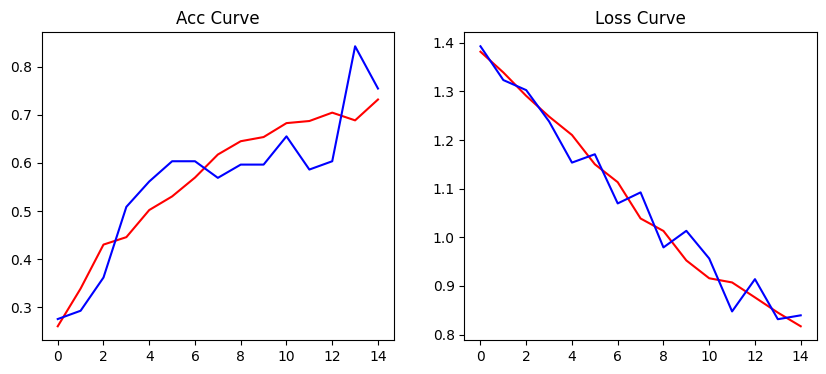

In [57]:
# print best epoch
max_index = hist["val_loss"].argmin()
print(hist["val_acc"].shape)
print("max_val_accindex : ", max_index)
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()



### fine-tuning (SI+FT)

In [58]:
### TD: build the fine-tuning dataloader ###
#copy some code from upper code, create data and put it into model
subject_id = "01"
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
print(x_data.shape,y_data.shape)
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat")) # load the .mat file
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

# simple train-valid split, only consider class balance (may not good enough), CAN be modified
for c in range(4):
    x_, y_ = x_data[y_data == c], y_data[y_data == c]
    x_train = np.append(x_train, x_[:54], axis=0)
    y_train = np.append(y_train, y_[:54], axis=0)
    x_valid = np.append(x_valid, x_[54:], axis=0)
    y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
# tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

concat_dataset = ConcatDataset([trainset, validset])
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
#######################################################################################################
# load pre-trained model
### TD ###
ep_num = max_index# TD: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# # Optional: lock pre-trained weight
# for param in model.parameters():
#     param.requires_grad = False

### TD: fine-tuning training loop ###
#copy some code from upper code, put it into model to train
epochs = 10
hist = dict(
    loss=np.zeros((epochs*k_folds*2, )), val_loss=np.zeros((epochs*k_folds*2, )),
    acc=np.zeros((epochs*k_folds*2, )), val_acc=np.zeros((epochs*k_folds*2, ))
)
clock_ini = time.time()
for k in range(2):
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(concat_dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = SubsetRandomSampler(train_ids)
        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_loader = DataLoader(concat_dataset, batch_size=16, sampler=train_subsampler)
        valid_loader = DataLoader(concat_dataset, batch_size=16, sampler=valid_subsampler)
        for ep in range(epochs):
            loss, acc = train_an_epoch(model, train_loader, loss_fn, opt_fn)
            loss, acc = evalate_an_epoch(model, train_loader, loss_fn)
            val_loss, val_acc = evalate_an_epoch(model, valid_loader, loss_fn)
            print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep+fold*epochs+k*k_folds*epochs, loss, acc, val_loss, val_acc))
            hist["loss"][ep+fold*epochs+k*k_folds*epochs] = loss
            hist["acc"][ep+fold*epochs+k*k_folds*epochs] = acc
            hist["val_loss"][ep+fold*epochs+k*k_folds*epochs] = val_loss
            hist["val_acc"][ep+fold*epochs+k*k_folds*epochs] = val_acc

            if True:
                # save the pre-trained weight in each epoch, CAN be modified
                checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
                torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep+fold*epochs+k*k_folds*epochs}.pth"))
        print("time spend: {:.2f} sec".format(time.time() - clock_ini))











(288, 22, 562) (288,)
(0, 22, 562) (0,) (0, 22, 562) (0,)
train: torch.Size([216, 1, 22, 562]), torch.Size([216, 4])
valid: torch.Size([72, 1, 22, 562]), torch.Size([72, 4])
FOLD 0
--------------------------------
Epoch 0: loss=0.8468, acc=0.7304, val_loss=0.7331, val_acc=0.7414
Epoch 1: loss=0.8117, acc=0.7304, val_loss=0.7221, val_acc=0.7241
Epoch 2: loss=0.7916, acc=0.7478, val_loss=0.7102, val_acc=0.7241
Epoch 3: loss=0.7679, acc=0.7696, val_loss=0.6980, val_acc=0.7069
Epoch 4: loss=0.7489, acc=0.7652, val_loss=0.6850, val_acc=0.7241
Epoch 5: loss=0.7232, acc=0.7826, val_loss=0.6805, val_acc=0.6897
Epoch 6: loss=0.7086, acc=0.7913, val_loss=0.6912, val_acc=0.7586
Epoch 7: loss=0.6797, acc=0.7826, val_loss=0.6592, val_acc=0.7414
Epoch 8: loss=0.6705, acc=0.8000, val_loss=0.6533, val_acc=0.7759
Epoch 9: loss=0.6468, acc=0.8043, val_loss=0.6633, val_acc=0.7759
time spend: 1.62 sec
FOLD 1
--------------------------------
Epoch 10: loss=0.6500, acc=0.7870, val_loss=0.6105, val_acc=0.827

max_val_accindex :  90


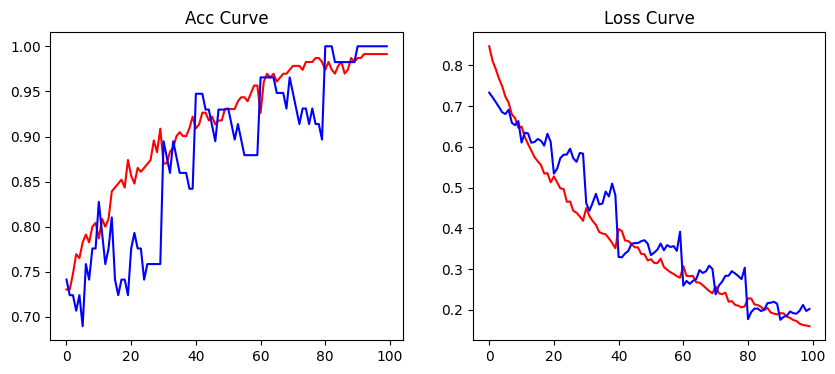

In [59]:
# print best epoch
max_index = hist["val_loss"].argmin()
print("max_val_accindex : ", max_index)
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()

## Test

In [60]:
# load pre-trained model
best_epoch = hist["val_loss"].argmin()# TD: determine the `BEST` epoch
print(best_epoch)
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
evalate_an_epoch(model, test_loader, loss_fn)

90
test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


(0.6669755164119933, 0.6875)

## Analyzing
You need to do some further analysis including
- confusion matrix, 
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

torch.Size([288]) torch.Size([288])


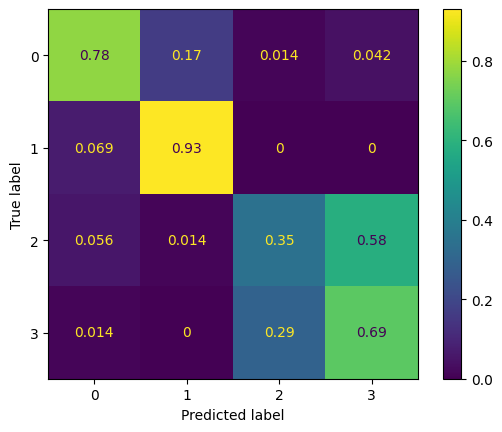

torch.Size([22, 1, 22, 1])


<Figure size 640x480 with 0 Axes>

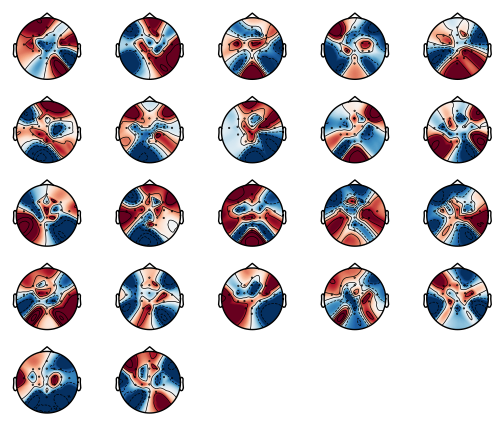

In [61]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from mne.viz import plot_topomap
def evalate_cm(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    idx = 0
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TD ###
        output = model(x_batch)# TD: get model prediction
        # loss = nn.CrossEntropyLoss()(output, y_batch)# TD: calc loss
        # epoch_loss[i] = loss.item()
        # b += y_batch.size(0)
        # a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
        if idx==0:
            y_p = output.argmax(dim=1)
            y_t = y_batch.argmax(dim=1)
        else:
            y_p = torch.cat((y_p,output.argmax(dim=1)))
            y_t = torch.cat((y_t,y_batch.argmax(dim=1)))
        idx = idx + 1

    print(y_p.shape,y_t.shape)
    cm = confusion_matrix(y_t.cpu().numpy(), y_p.cpu().numpy())
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalizing the confusion matrix
    cm_display = ConfusionMatrixDisplay(cm).plot()
    plt.show()
    plt.savefig('confusion_matrix.png')
    
    return 

#draw confusion matrix
evalate_cm(model, test_loader, loss_fn)



#create topomap
W = model.conv1.weight
print(W.shape) #22,1,22,1
# Set up a layout for the channel locations
ch_names = ["Fz","FC3","FC1","FCz","FC2","FC4","T7","C3","C1","Cz","C2","C4",
"T8","CP3","CP1","CPz","CP2","CP4","P1","Pz","P2","POz"]

# Create an Info object
info = mne.create_info(ch_names, sfreq=125, ch_types=['eeg']*22)
info.set_montage('standard_1020')


fig, ax = plt.subplots(5,5)
ax[4,2].set_visible(False)
ax[4,3].set_visible(False)
ax[4,4].set_visible(False)
# Plot topographic maps for each weight
for i in range(W.shape[0]):
    #print(int((i)/5),(i)%5)
    plot_topomap(W[i][0].to("cpu").detach().numpy().reshape(22), pos = info, show=False,axes = ax[int((i)/5)][i%5])

plt.savefig("plot_topomap.png")
plt.show()

## Generate Submission csv File

In [ ]:
eegmodel = ShallowConvNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict() # custom args for different EEG model fs=125.0, dropoutRate=0.5
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("simple_sd.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
device = "cpu"
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()